In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
import sys
import glob
import pandas as pd
import os
import seaborn as sns

from tqdm import tqdm
from statsmodels.distributions.empirical_distribution import ECDF
from collections import defaultdict
import pickle
import re
import json
from pathlib import Path
import scipy.stats
import time

from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_plotting_utils import *
from open_spiel.python.examples.ubc_sample_game_tree import sample_game_tree, flatten_trees, flatten_tree
from open_spiel.python.examples.ubc_clusters import projectPCA, fitGMM
from open_spiel.python.examples.ubc_utils import *
import open_spiel.python.examples.ubc_dispatch as dispatch

from auctions.webutils import *

os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

from open_spiel.python.examples.ubc_cma import *

output_notebook()
from open_spiel.python.games.clock_auction_base import InformationPolicy, ActivityPolicy, UndersellPolicy, TiebreakingPolicy, action_to_bundles
from open_spiel.python.algorithms.exploitability import nash_conv, best_response
from open_spiel.python.examples.ubc_decorators import TakeSingleActionDecorator, TremblingAgentDecorator, ModalAgentDecorator

plt.style.use('https://raw.githubusercontent.com/gregdeon/plots/main/style.mplstyle')

Loading BokehJS ...

# Sampler

In [24]:
import copy
from open_spiel.python.examples.sats_game_sampler import test_config_is_wieldy 
from open_spiel.python.examples.pysats import map_generators, run_sats


In [25]:
action_to_bundles([3, 2])

array([[0, 0],
       [0, 1],
       [0, 2],
       [1, 0],
       [1, 1],
       [1, 2],
       [2, 0],
       [2, 1],
       [2, 2],
       [3, 0],
       [3, 1],
       [3, 2]])

In [26]:
seed = 1234
external = True
output='configs/jan9v3.pkl'

N_CONFIGS = 5
MIN_TYPES = 3
MAX_TYPES = 3
MIN_BIDDERS = 2
MAX_BIDDERS = 2
MAX_ACTION_SPACE = 27
MAX_NUM_LICENSES = 6
ACTION_PREFIX = [9, 9, 9]

In [27]:
# TODO: see more magic constants in the wieldy function

failures = defaultdict(int)

configs = []
base = {
    'scale': 1_000_000,
    'auction_params': {
        'increment': .05,
        'max_rounds': 15, 
        'heuristic_deviations': 0,
    },
    'bidders': [
    ]
}
base['auction_params']['agent_memory'] = base['auction_params']['max_rounds']

iters = 0
rng = np.random.default_rng(seed=seed)

with tqdm() as pbar:
    while len(configs) < N_CONFIGS:
        iters += 1
        pbar.update(1)

        sats_seed = rng.integers(int(1e9))
        x = copy.deepcopy(base)
        x['sats_seed'] = sats_seed
        x['map'] = 'BCEncumbered'

        map_generator, bid_to_quantity_matrix = map_generators[x['map']]
        selected_map = map_generator()
        if bid_to_quantity_matrix is None:
            bid_to_quantity_matrix = np.eye(len(selected_map))

        num_regions, num_products = bid_to_quantity_matrix.shape
        licenses = [3, 2]

        ap = x['auction_params']
        ap['licenses'] = licenses

        license_mhz = 10
        mhz_per_pop_open = 0.232 # Real value (for 3800 I think?)

        region_opening_prices = np.array([int(np.round(license_mhz * mhz_per_pop_open * node.population / x['scale'])) for node in selected_map])
        product_opening_prices = region_opening_prices @ bid_to_quantity_matrix # opening prices of encumbered licenses are proportional to bandwidth
        product_opening_prices = np.clip(product_opening_prices, np.min(region_opening_prices) * 0.05, None) # signalling products are worth 5% of cheapest region
        product_opening_prices = np.array([int(np.round(p)) for p in product_opening_prices])
        ap['opening_price'] = product_opening_prices.tolist()
        ap['activity'] = [op for op in ap['opening_price']]

        bidders = x['bidders']
        n_bidders = rng.integers(MIN_BIDDERS, MAX_BIDDERS + 1)

        for j in range(n_bidders):
            bidder_types = []
            bidders.append({
                'player': j,
                'types': bidder_types,
                'action_prefix': ACTION_PREFIX,
            })
            for _ in range(rng.integers(MIN_TYPES, MAX_TYPES + 1)):
                bidder = {
                    'type': 'local',
                    'value_per_subscriber': {
                        'lower': 30,
                        'upper': 50,
                    },
                    'market_share': {
                        'lower': 0.20,
                        'upper': 0.50,
                    },
                    'local_regions': [1],
                }

                bidder_types.append(bidder)
                
        retval = test_config_is_wieldy(x, external=external)
        if not retval['failed']:
            print("SUCCESS")
            print(x)
            print(retval['sats_config'])
            configs.append(x)
            with open(output, 'wb') as f: # Will keep overwriting
                pickle.dump(configs, f)
            print(f"Acceptance rate is {len(configs) / iters:.5%}")
        else:
            failures[retval['failure_reason']] += 1
            if retval['failure_reason'] == 'Slow MCCFR iters':
                print(failures) 

48it [00:03, 15.31it/s]

Starting test for slowness


50it [00:06,  1.69it/s]

Speed of 582.03 iters/s
SUCCESS
{'scale': 1000000, 'auction_params': {'increment': 0.05, 'max_rounds': 15, 'heuristic_deviations': 0, 'agent_memory': 15, 'licenses': [3, 2], 'opening_price': [12, 8], 'activity': [12, 8]}, 'bidders': [{'player': 0, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}], 'action_prefix': [9, 9, 9]}, {'player': 1, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions':

68it [00:07, 11.80it/s]

Starting test for slowness
Speed of 590.11 iters/s
SUCCESS
{'scale': 1000000, 'auction_params': {'increment': 0.05, 'max_rounds': 15, 'heuristic_deviations': 0, 'agent_memory': 15, 'licenses': [3, 2], 'opening_price': [12, 8], 'activity': [12, 8]}, 'bidders': [{'player': 0, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}], 'action_prefix': [9, 9, 9]}, {'player': 1, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upp

308it [00:28, 15.19it/s]

Starting test for slowness
Speed of 571.96 iters/s
SUCCESS
{'scale': 1000000, 'auction_params': {'increment': 0.05, 'max_rounds': 15, 'heuristic_deviations': 0, 'agent_memory': 15, 'licenses': [3, 2], 'opening_price': [12, 8], 'activity': [12, 8]}, 'bidders': [{'player': 0, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}], 'action_prefix': [9, 9, 9]}, {'player': 1, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upp

340it [00:34, 14.54it/s]

Starting test for slowness
Speed of 590.10 iters/s
SUCCESS
{'scale': 1000000, 'auction_params': {'increment': 0.05, 'max_rounds': 15, 'heuristic_deviations': 0, 'agent_memory': 15, 'licenses': [3, 2], 'opening_price': [12, 8], 'activity': [12, 8]}, 'bidders': [{'player': 0, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}], 'action_prefix': [9, 9, 9]}, {'player': 1, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upp

384it [00:40, 15.04it/s]

Starting test for slowness


385it [00:50,  7.60it/s]

Speed of 210.29 iters/s
SUCCESS
{'scale': 1000000, 'auction_params': {'increment': 0.05, 'max_rounds': 15, 'heuristic_deviations': 0, 'agent_memory': 15, 'licenses': [3, 2], 'opening_price': [12, 8], 'activity': [12, 8]}, 'bidders': [{'player': 0, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}], 'action_prefix': [9, 9, 9]}, {'player': 1, 'types': [{'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions': [1]}, {'type': 'local', 'value_per_subscriber': {'lower': 30, 'upper': 50}, 'market_share': {'lower': 0.2, 'upper': 0.5}, 'local_regions':

In [ ]:
failures

defaultdict(int,
            {'There exists a combo that does not sell everything': 491,
             'Straightforward too long': 169,
             'There exists a type that is hopelessly weak (never allocated)': 3,
             'Not enough competition': 13})

# Details about samples

In [28]:
with open(output,'rb') as f:
    sampled_configs = pickle.load(f)

In [29]:
bundles = action_to_bundles([3, 2])
spectrum_per_license = np.array([1, 0.7]).reshape(-1, 1)
bandwidths = (bundles @ spectrum_per_license).flatten()
idx = np.argsort(bandwidths)

In [30]:
12 * 1.05**3, 8

(13.8915, 8)

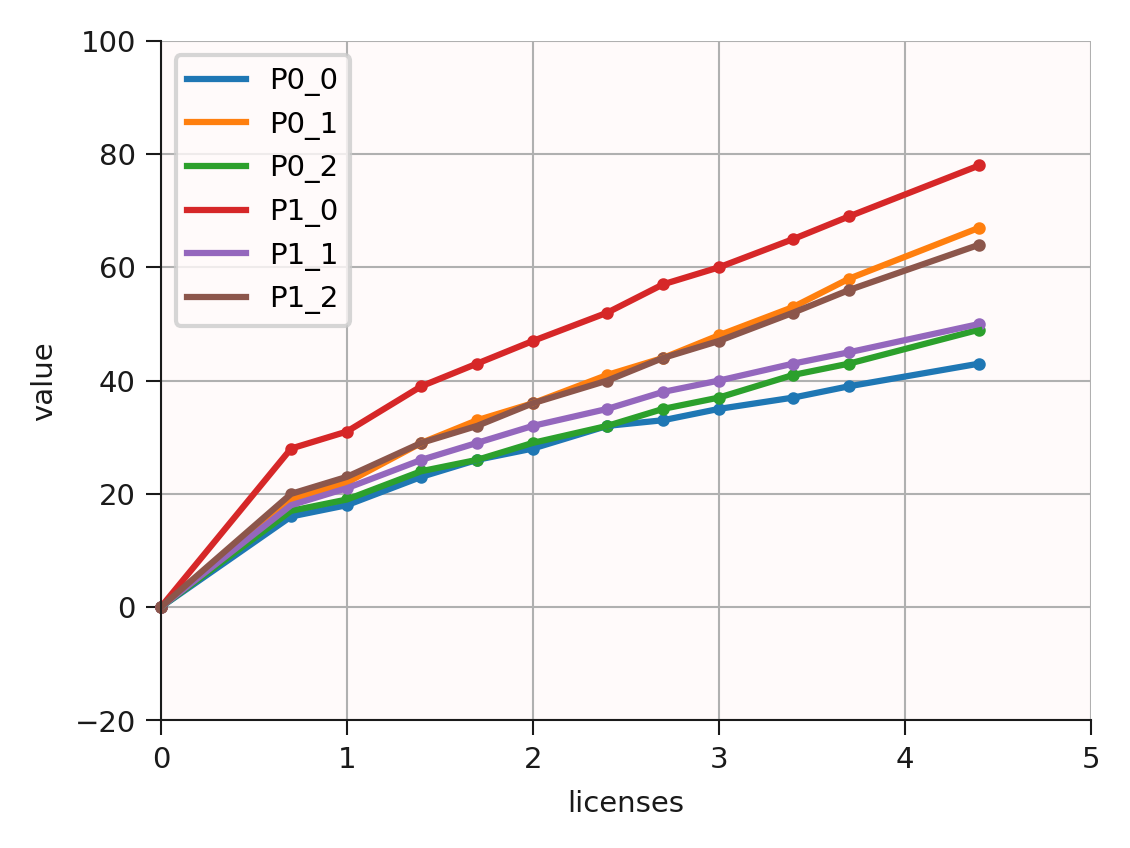

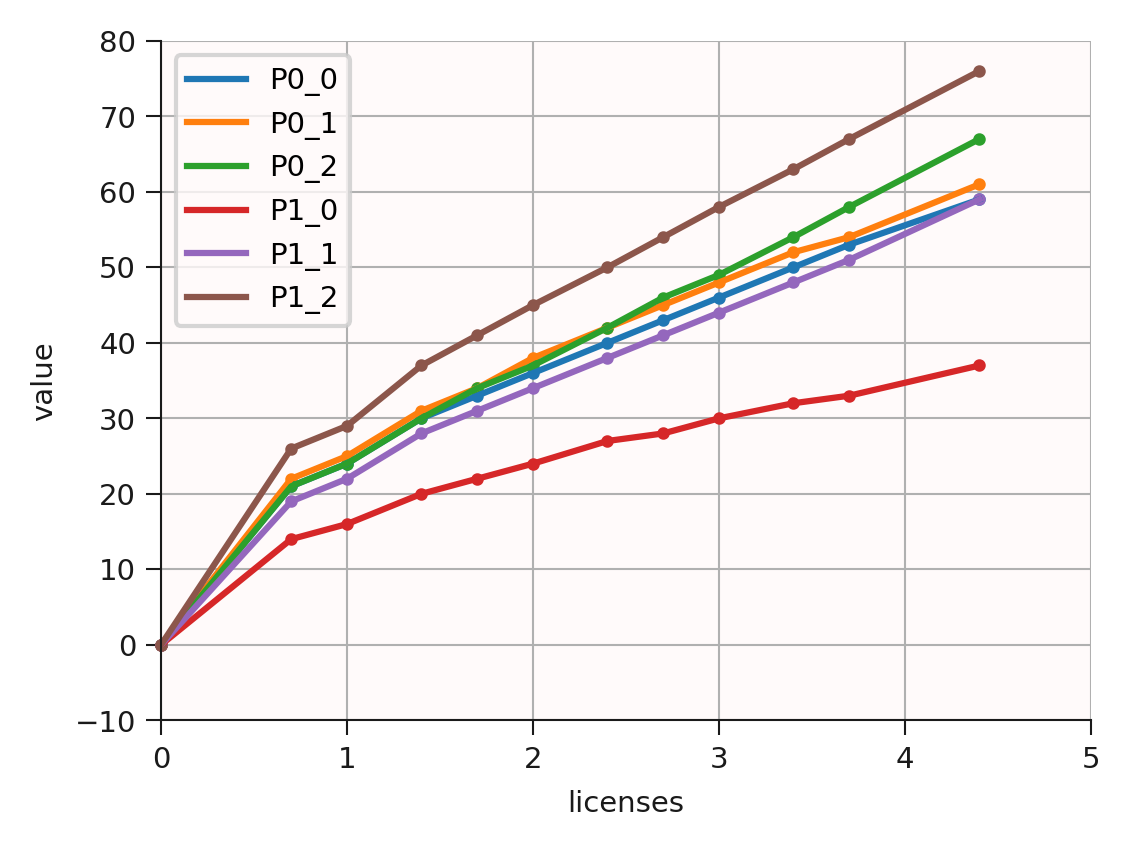

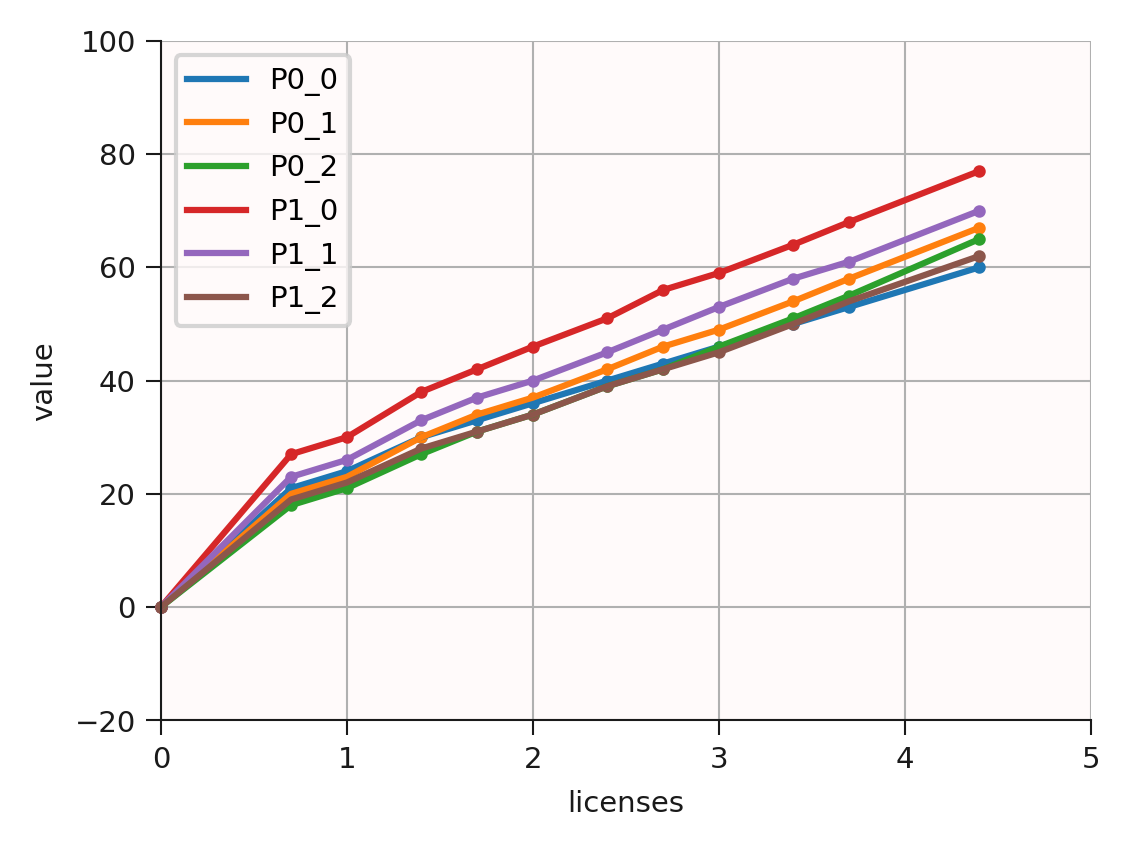

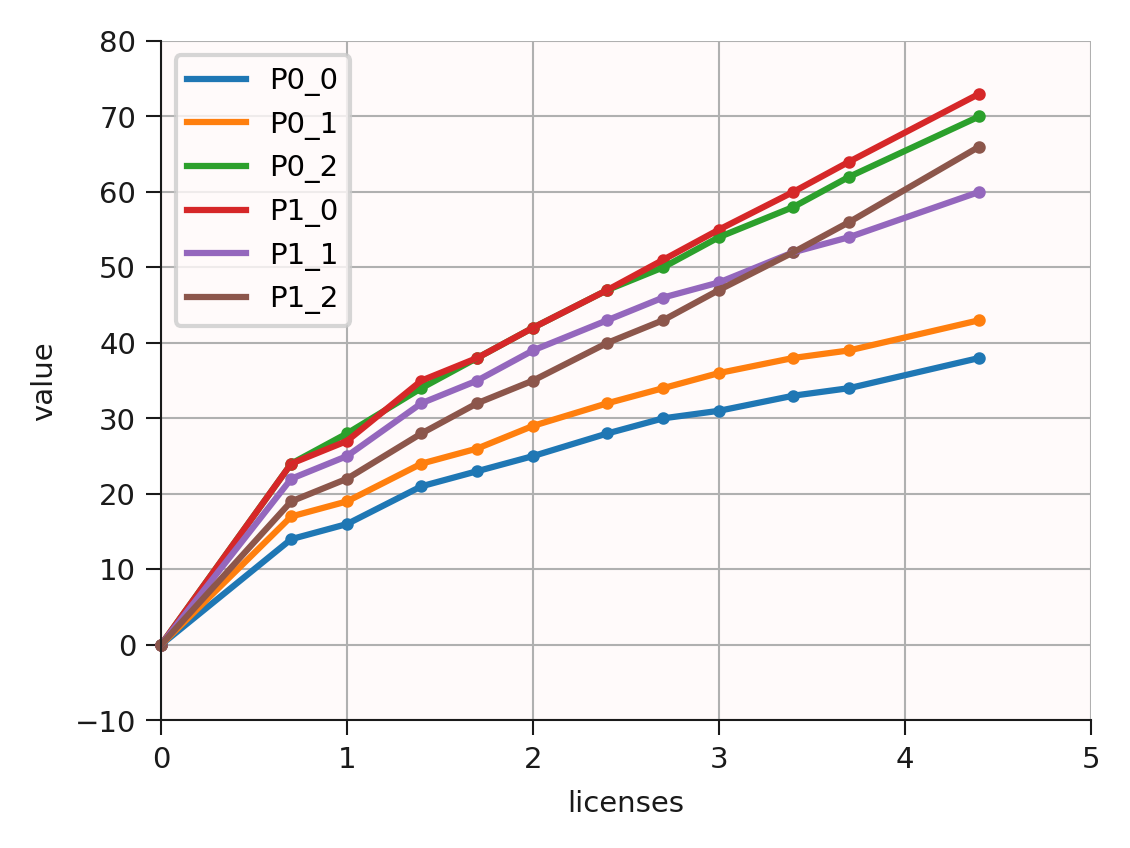

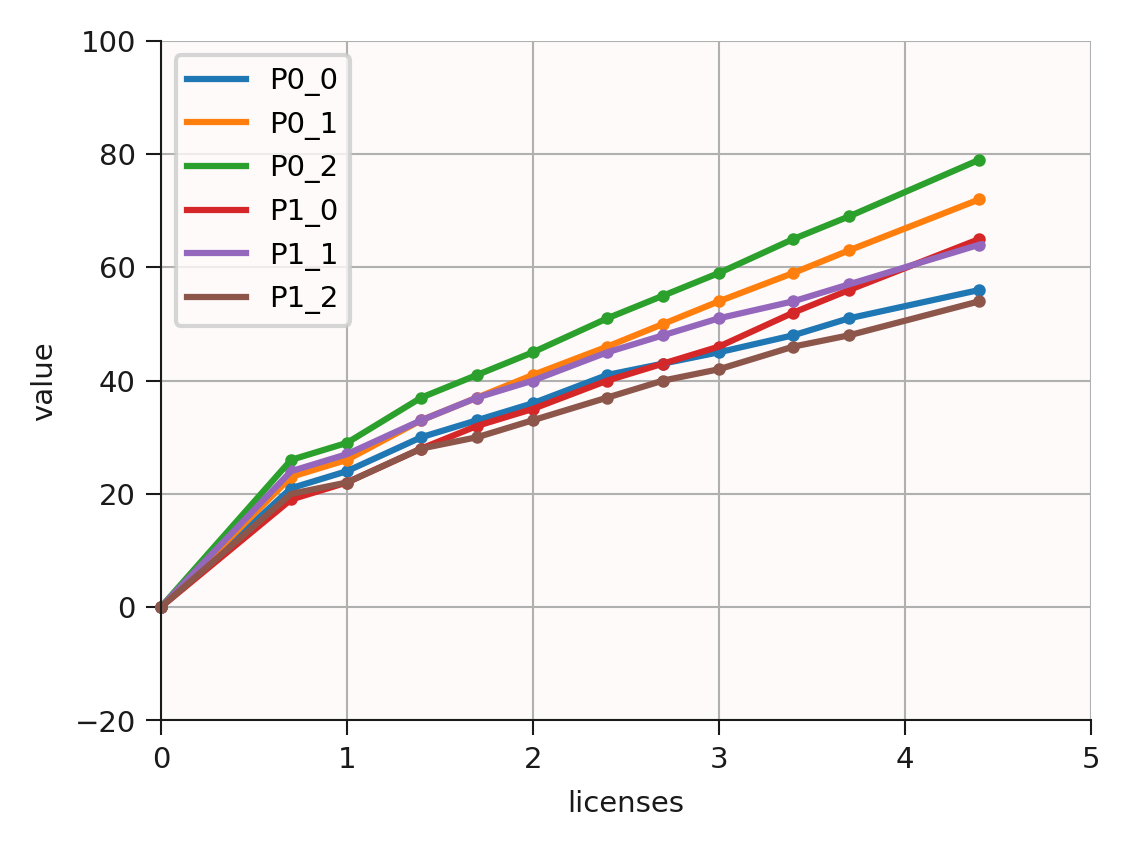

In [31]:
# What do values look for at the starting clocks, after you've done the action prefix? # Note; not automated at all, very manual
for i in range(len(sampled_configs)):
    config = sampled_configs[i]
    with tempfile.NamedTemporaryFile(mode='w+', delete=False) as fp:
        sats_config = run_sats(config, fp.name, seed=config['sats_seed'])

    bundles = action_to_bundles([3, 2])
    spectrum_per_license = np.array([1, 0.7]).reshape(-1, 1)
    bandwidths = (bundles @ spectrum_per_license).flatten()
    idx = np.argsort(bandwidths)

    for player_id in range(len(sats_config['players'])):
        for type_id in range(len(sats_config['players'][player_id]['type'])):
            values = np.array(sats_config['players'][player_id]['type'][type_id]['value']) 
            plt.plot(bandwidths[idx], values[idx], label=f'P{player_id}_{type_id}')
            plt.scatter(bandwidths[idx], values[idx], s=4, clip_on=False)
    plt.legend()
    plt.xlabel('licenses')
    plt.ylabel('value')
    plt.xlim(0, None)
    plt.show()